In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium # 지도 시각화를 위한 라이브러리
from folium.plugins import TimestampedGeoJson # 시간 변화에 따른 마커 시각화를 위한 플러그인
import json

In [3]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [4]:
import pandas as pd

seoul_file_path = '/content/mydrive/MyDrive/Colab Notebooks/DSL25-2/EDA/apart_0731_seoul.csv'
incheon_file_path = '/content/mydrive/MyDrive/Colab Notebooks/DSL25-2/EDA/apart_0731_incheon.csv'
gyeonggi_file_path = '/content/mydrive/MyDrive/Colab Notebooks/DSL25-2/EDA/apart_0731_gyeonggi.csv'

# Read the CSV files into dataframes, skipping the first 15 rows
try:
    df_seoul = pd.read_csv(seoul_file_path, encoding='utf-8', skiprows=15)
except UnicodeDecodeError:
    df_seoul = pd.read_csv(seoul_file_path, encoding='cp949', skiprows=15)

try:
    df_incheon = pd.read_csv(incheon_file_path, encoding='utf-8', skiprows=15)
except UnicodeDecodeError:
    df_incheon = pd.read_csv(incheon_file_path, encoding='cp949', skiprows=15)

try:
    df_gyeonggi = pd.read_csv(gyeonggi_file_path, encoding='utf-8', skiprows=15)
except UnicodeDecodeError:
    df_gyeonggi = pd.read_csv(gyeonggi_file_path, encoding='cp949', skiprows=15)

# Function to remove the last word from '시군구' if it ends with '리'
def remove_last_word_if_ri(s):
    if isinstance(s, str) and s.endswith('리'):
        return ' '.join(s.split()[:-1])
    return s

# Apply the function to the '시군구' column in each dataframe
df_seoul['시군구'] = df_seoul['시군구'].apply(remove_last_word_if_ri)
df_incheon['시군구'] = df_incheon['시군구'].apply(remove_last_word_if_ri)
df_gyeonggi['시군구'] = df_gyeonggi['시군구'].apply(remove_last_word_if_ri)


# Concatenate the dataframes
df_combined = pd.concat([df_seoul, df_incheon, df_gyeonggi], ignore_index=True)

print("Combined dataframe head:")
display(df_combined.head())

print("\nCombined dataframe info:")
df_combined.info()

Combined dataframe head:


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,서울특별시 강북구 수유동,739,739,0,북한산스카이뷰아파트,56.96,202507,30,"42,000",-,3,개인,개인,2020,4.19로9길 18,-,중개거래,서울 강북구,-
1,2,서울특별시 성북구 하월곡동,230,230,0,동일하이빌뉴시티,178.84,202507,30,"105,000",-,14,개인,개인,2011,종암로 167,-,중개거래,경기 남양주시,-
2,3,서울특별시 마포구 용강동,380,380,0,마포용강삼성래미안,131.79,202507,30,"205,000",-,2,개인,개인,2003,큰우물로 28,-,중개거래,"서울 강남구, 서울 마포구",-
3,4,서울특별시 강서구 마곡동,1513,1513,0,마곡경남아너스빌,84.98,202507,30,"60,000",-,1,개인,개인,2007,방화대로34길 62,-,직거래,-,-
4,5,서울특별시 서대문구 홍은동,440-3,440,3,풍림1차,56.61,202507,29,"32,000",-,6,개인,개인,1988,통일로48가길 37,-,중개거래,경기 안양시 동안구,-



Combined dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148745 entries, 0 to 148744
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NO        148745 non-null  int64  
 1   시군구       148745 non-null  object 
 2   번지        148745 non-null  object 
 3   본번        148745 non-null  int64  
 4   부번        148745 non-null  int64  
 5   단지명       148745 non-null  object 
 6   전용면적(㎡)   148745 non-null  float64
 7   계약년월      148745 non-null  int64  
 8   계약일       148745 non-null  int64  
 9   거래금액(만원)  148745 non-null  object 
 10  동         148745 non-null  object 
 11  층         148745 non-null  int64  
 12  매수자       148745 non-null  object 
 13  매도자       148745 non-null  object 
 14  건축년도      148745 non-null  int64  
 15  도로명       148745 non-null  object 
 16  해제사유발생일   148745 non-null  object 
 17  거래유형      148745 non-null  object 
 18  중개사소재지    148745 non-null  object 
 19  등기일자      148745 n

In [5]:
# 필요한 컬럼 선택
# '시군구', '계약년월', '전용면적(㎡)', '거래금액(만원)'
df_selected = df_combined[['시군구', '계약년월', '전용면적(㎡)', '거래금액(만원)']]

# 데이터 타입 변환 및 전처리
# '거래금액(만원)'에서 쉼표(,) 제거 후 숫자형으로 변환
df_selected['거래금액(만원)'] = df_selected['거래금액(만원)'].str.replace(',', '').astype(float)
df_selected['전용면적(㎡)'] = df_selected['전용면적(㎡)'].astype(float)

# 평당 가격 계산 (1평 = 3.30579㎡)
df_selected['평당가격(만원/평)'] = (df_selected['거래금액(만원)'] / df_selected['전용면적(㎡)']) * 3.30579

# '계약년월'을 월 단위로 변환 (예: 202501 -> 1, 202502 -> 2)
# '계약년월'이 YYYYMM 형태의 숫자이므로, 뒤 두자리를 월로 사용하거나, datetime 객체로 변환하여 월만 추출
df_selected['계약년월'] = pd.to_datetime(df_selected['계약년월'].astype(str), format='%Y%m')
df_selected['계약월'] = df_selected['계약년월'].dt.month
df_selected.head()

# 지역별, 월별 평균 평당 가격 집계
df_grouped = df_selected.groupby(['시군구', '계약월'])['평당가격(만원/평)'].mean().reset_index()

print("전처리된 데이터 상위 5개 행:")
print(df_grouped.head())

전처리된 데이터 상위 5개 행:
           시군구  계약월  평당가격(만원/평)
0  경기도 가평군 가평읍    1  954.507378
1  경기도 가평군 가평읍    2  979.968498
2  경기도 가평군 가평읍    3  990.821512
3  경기도 가평군 가평읍    4  884.899389
4  경기도 가평군 가평읍    5  709.320316


/tmp/ipython-input-3142708581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['거래금액(만원)'] = df_selected['거래금액(만원)'].str.replace(',', '').astype(float)
/tmp/ipython-input-3142708581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['전용면적(㎡)'] = df_selected['전용면적(㎡)'].astype(float)
/tmp/ipython-input-3142708581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Pivoted data for clustering (head):


계약월,1,2,3,4,5,6,7
시군구,,,,,,,
경기도 가평군 가평읍,954.507378,979.968498,990.821512,884.899389,709.320316,992.767875,1053.035031
경기도 가평군 상면,417.548358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
경기도 가평군 설악면,0.000000,0.000000,1129.854868,1159.732543,0.000000,1080.725081,1106.384360
경기도 가평군 청평면,825.533474,872.376083,828.705689,749.539225,793.516551,815.810910,893.244894
경기도 고양시 덕양구 고양동,1233.927225,1210.628318,1134.414830,1143.655203,1214.366701,1189.719460,1221.576635



Scaled monthly data (first 5 rows):
[[-0.71996028 -0.74225019 -0.76980979 -0.73465589 -0.88168618 -0.75307775
  -0.62069086]
 [-0.9657679  -1.17261922 -1.20628367 -1.11364028 -1.19043001 -1.17251472
  -1.06145228]
 [-1.15691204 -1.17261922 -0.70856321 -0.61695044 -1.19043001 -0.71591649
  -0.59836081]
 [-0.7790016  -0.78950114 -0.84122459 -0.79262789 -0.84503832 -0.82784074
  -0.68757309]
 [-0.59204823 -0.64095219 -0.70655447 -0.62383604 -0.66185608 -0.66986718
  -0.55014559]]


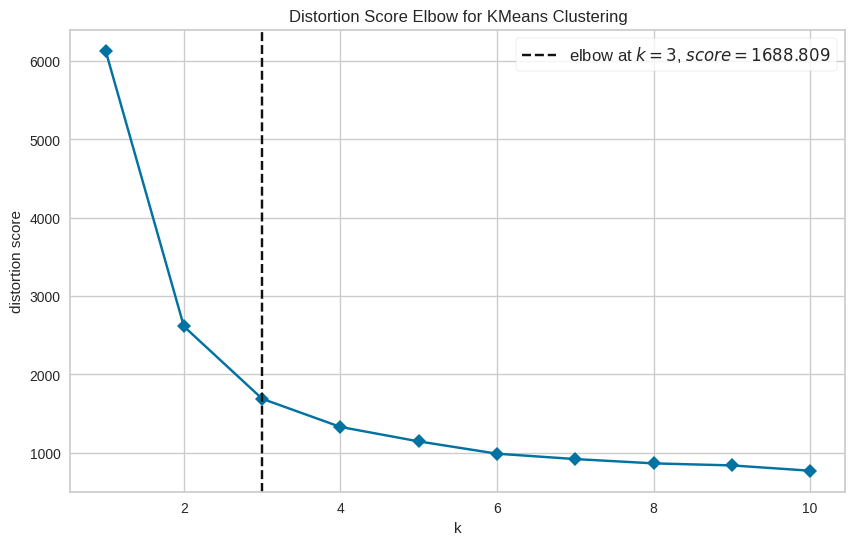

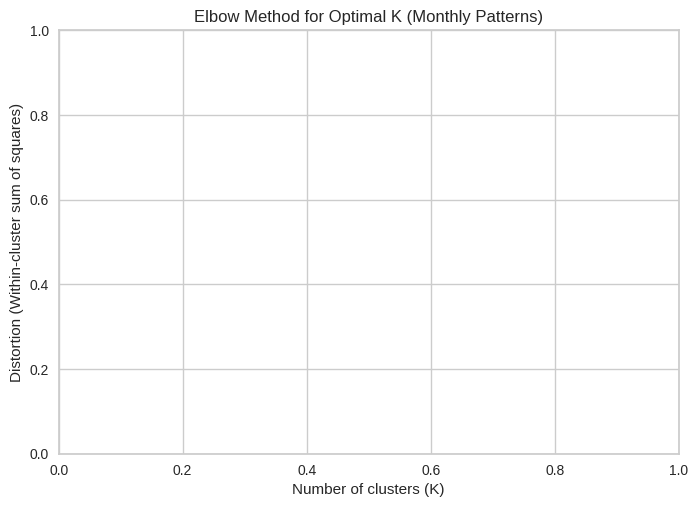


Review the Elbow Method plot to choose the optimal K for monthly clustering.


In [6]:
# Reshape the data for clustering based on monthly patterns
# Pivot the df_grouped data so that rows are '시군구', columns are '계약월', and values are '평당가격(만원/평)'
df_pivot = df_grouped.pivot_table(index='시군구', columns='계약월', values='평당가격(만원/평)')

# Fill any missing values (if a region doesn't have data for a specific month) with 0 or the mean/median
# Using 0 for simplicity, but consider other imputation methods if necessary
df_pivot = df_pivot.fillna(0)

print("Pivoted data for clustering (head):")
display(df_pivot.head())

# Prepare data for clustering
X_monthly = df_pivot.values

# Scale the data
scaler_monthly = StandardScaler()
X_monthly_scaled = scaler_monthly.fit_transform(X_monthly)

print("\nScaled monthly data (first 5 rows):")
print(X_monthly_scaled[:5])

# Determine the optimal number of clusters (K) using the Elbow Method
model_monthly = KMeans(random_state=42, n_init='auto')
plt.figure(figsize=(10, 6))
visualizer_monthly = KElbowVisualizer(model_monthly, k=(1, 11), timings=False) # Check K from 1 to 10
visualizer_monthly.fit(X_monthly_scaled)
visualizer_monthly.show()
plt.title('Elbow Method for Optimal K (Monthly Patterns)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion (Within-cluster sum of squares)')
plt.show()

print("\nReview the Elbow Method plot to choose the optimal K for monthly clustering.")

월별 패턴 클러스터링 결과 (상위 5개 행):


계약월,1,2,3,4,5,6,7,cluster
시군구,,,,,,,,
경기도 가평군 가평읍,954.507378,979.968498,990.821512,884.899389,709.320316,992.767875,1053.035031,2
경기도 가평군 상면,417.548358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
경기도 가평군 설악면,0.000000,0.000000,1129.854868,1159.732543,0.000000,1080.725081,1106.384360,2
경기도 가평군 청평면,825.533474,872.376083,828.705689,749.539225,793.516551,815.810910,893.244894,2
경기도 고양시 덕양구 고양동,1233.927225,1210.628318,1134.414830,1143.655203,1214.366701,1189.719460,1221.576635,2


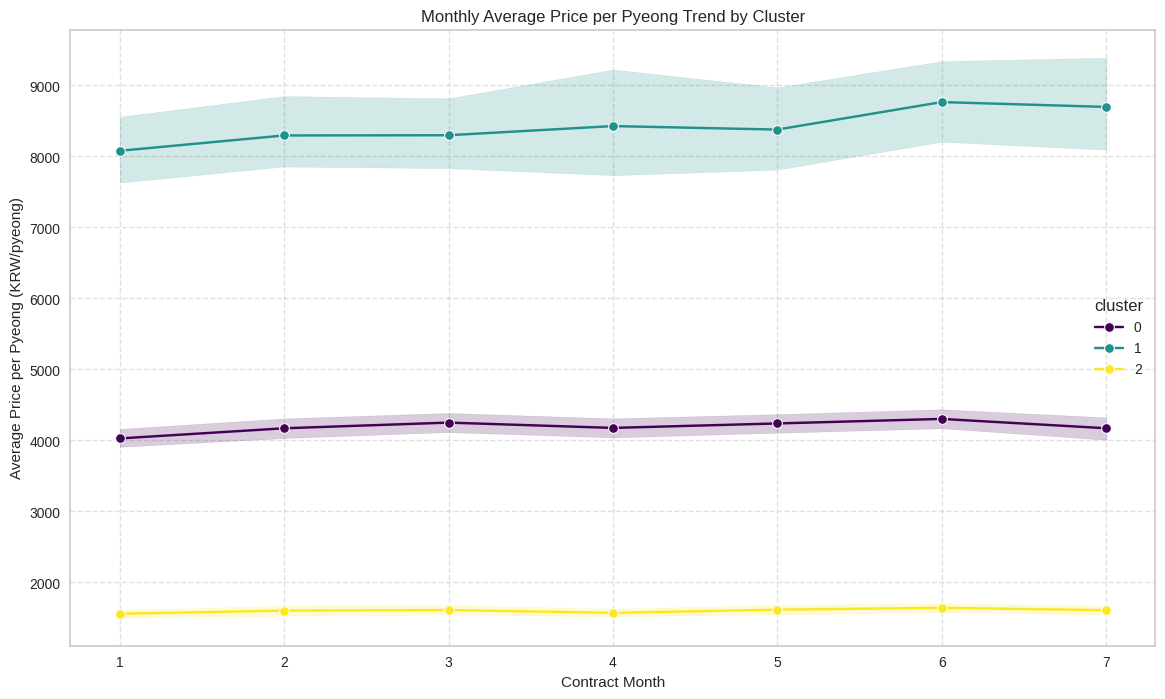


클러스터별 전체 월평균 평당 가격:
   cluster   평당가격(만원/평)
0        2  1602.404598
1        0  4192.678309
2        1  8418.946765

각 클러스터에 속한 주요 시군구 (상위 10개 예시):

--- 클러스터 0 ---
시군구
인천광역시 연수구 송도동       7
경기도 고양시 덕양구 덕은동     7
경기도 고양시 덕양구 도내동     7
경기도 고양시 덕양구 동산동     7
경기도 고양시 덕양구 삼송동     7
경기도 고양시 덕양구 원흥동     7
경기도 고양시 덕양구 지축동     7
경기도 고양시 덕양구 향동동     7
경기도 고양시 일산동구 장항동    7
서울특별시 종로구 창신동       7
Name: count, dtype: int64

상위 10개 시군구의 평균 평당 가격:
시군구
서울특별시 용산구 보광동      8978.211133
서울특별시 종로구 교북동      7957.623064
서울특별시 용산구 한강로2가    7477.929117
서울특별시 용산구 원효로3가    7395.446976
서울특별시 중구 입정동       7170.517910
경기도 성남시 분당구 삼평동    6708.776911
서울특별시 성동구 상왕십리동    6567.194523
서울특별시 용산구 원효로1가    6530.821399
서울특별시 마포구 토정동      6352.838047
서울특별시 용산구 한강로1가    6352.066393
Name: 평당가격(만원/평), dtype: float64

--- 클러스터 1 ---
시군구
경기도 과천시 별양동        7
경기도 과천시 부림동        7
경기도 과천시 원문동        7
경기도 성남시 분당구 백현동    7
서울특별시 강남구 개포동      7
서울특별시 강남구 삼성동      7
서울특별시 강남구 논현동      7
서울특별시 강남구 대치동      7
서울특별시 강남구 도곡동      7
서울특별시 

In [7]:
# K-평균 클러스터링 수행 (K=3)
kmeans_model_monthly = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters_monthly = kmeans_model_monthly.fit_predict(X_monthly_scaled)

# 클러스터 라벨을 피벗된 데이터프레임에 추가
df_pivot['cluster'] = clusters_monthly

print("월별 패턴 클러스터링 결과 (상위 5개 행):")
display(df_pivot.head())

# 각 클러스터의 특성 분석
# 클러스터별 월별 평균 평당 가격 추세 시각화 (선 그래프)
# 클러스터 라벨을 df_grouped 데이터프레임에 병합하여 원본 데이터와 함께 분석
df_grouped_with_clusters = df_grouped.merge(df_pivot[['cluster']], left_on='시군구', right_index=True)

plt.figure(figsize=(14, 8))
sns.lineplot(x='계약월', y='평당가격(만원/평)', hue='cluster', data=df_grouped_with_clusters, marker='o', palette='viridis')
plt.title('Monthly Average Price per Pyeong Trend by Cluster')
plt.xlabel('Contract Month')
plt.ylabel('Average Price per Pyeong (KRW/pyeong)')
plt.xticks(range(1, 8)) # 1월부터 8월까지 표시
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='cluster')
plt.show()

# 클러스터별 평균 평당 가격 (전체 월 평균)
cluster_overall_means = df_grouped_with_clusters.groupby('cluster')['평당가격(만원/평)'].mean().sort_values().reset_index()
print("\n클러스터별 전체 월평균 평당 가격:")
print(cluster_overall_means)

# 각 클러스터에 어떤 지역들이 주로 속해 있는지 확인 (상위 10개 시군구)
print("\n각 클러스터에 속한 주요 시군구 (상위 10개 예시):")
for i in sorted(df_pivot['cluster'].unique()):
    print(f"\n--- 클러스터 {i} ---")
    cluster_regions = df_pivot[df_pivot['cluster'] == i].index.tolist()
    # 해당 클러스터에 속한 시군구 중 데이터가 가장 많은 상위 10개 출력 (예시)
    # 실제 데이터 개수는 df_grouped_with_clusters에서 확인해야 정확
    top_regions_in_cluster = df_grouped_with_clusters[df_grouped_with_clusters['cluster'] == i]['시군구'].value_counts().head(10)
    print(top_regions_in_cluster)

    # 해당 클러스터 내 시군구별 평균 평당 가격
    region_avg_price_in_cluster = df_grouped_with_clusters[df_grouped_with_clusters['cluster'] == i].groupby('시군구')['평당가격(만원/평)'].mean().sort_values(ascending=False).head(10)
    print("\n상위 10개 시군구의 평균 평당 가격:")
    print(region_avg_price_in_cluster)

In [8]:
# Merge df_selected with the cluster labels from df_pivot
# df_pivot is indexed by '시군구', so we merge on '시군구' from df_selected and the index of df_pivot
df_selected_with_clusters = df_selected.merge(df_pivot[['cluster']], left_on='시군구', right_index=True, how='left')

print("데이터프레임에 클러스터 번호가 추가된 결과 (상위 5개 행):")
display(df_selected_with_clusters.head())

print("\n클러스터 번호가 추가된 데이터프레임 정보:")
df_selected_with_clusters.info()

데이터프레임에 클러스터 번호가 추가된 결과 (상위 5개 행):


,시군구,계약년월,전용면적(㎡),거래금액(만원),평당가격(만원/평),계약월,cluster
0,서울특별시 강북구 수유동,2025-07-01,56.96,42000.0,2437.555829,7,2
1,서울특별시 성북구 하월곡동,2025-07-01,178.84,105000.0,1940.885428,7,0
2,서울특별시 마포구 용강동,2025-07-01,131.79,205000.0,5142.172775,7,1
3,서울특별시 강서구 마곡동,2025-07-01,84.98,60000.0,2334.048011,7,0
4,서울특별시 서대문구 홍은동,2025-07-01,56.61,32000.0,1868.667727,7,0



클러스터 번호가 추가된 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148745 entries, 0 to 148744
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   시군구         148745 non-null  object        
 1   계약년월        148745 non-null  datetime64[ns]
 2   전용면적(㎡)     148745 non-null  float64       
 3   거래금액(만원)    148745 non-null  float64       
 4   평당가격(만원/평)  148745 non-null  float64       
 5   계약월         148745 non-null  int32         
 6   cluster     148745 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(1)
memory usage: 6.8+ MB


# GeoJson 파일을 통해 읍면동 단위 시각화 해보기

In [9]:
import json
import geopandas as gpd
import pandas as pd
import folium

path = '/content/mydrive/MyDrive/Colab Notebooks/DSL25-2/EDA/'
df_sido = gpd.read_file(path + 'ctprvn.json')
df_sig = gpd.read_file(path + 'sig.json')
df_emd = gpd.read_file(path + 'emd.json')

In [10]:
display(df_sido.head())
display(df_sig.head())
display(df_emd.head())

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364..."
1,26,Busan,부산광역시,"MULTIPOLYGON (((129.28816 35.32116, 129.28817 ..."
2,27,Daegu,대구광역시,"POLYGON ((128.47278 35.83345, 128.47319 35.833..."
3,28,Incheon,인천광역시,"MULTIPOLYGON (((125.79162 36.92244, 125.79176 ..."
4,29,Gwangju,광주광역시,"POLYGON ((126.76029 35.2587, 126.75953 35.2585..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581..."
1,11140,Jung-gu,중구,"POLYGON ((127.02337 37.57191, 127.02336 37.571..."
2,11170,Yongsan-gu,용산구,"POLYGON ((126.96918 37.55566, 126.96716 37.554..."
3,11200,Seongdong-gu,성동구,"POLYGON ((127.07238 37.55996, 127.07226 37.560..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((127.07823 37.57189, 127.0782 37.5718..."


,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97468 37.591..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97023 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97398 37.58653..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97356 37.583..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97343 37.581..."


In [11]:
# Filter df_sido to keep only rows where CTPRVN_CD is 11, 28, or 41
df_sido_filtered = df_sido[df_sido['CTPRVN_CD'].isin(['11', '28', '41'])]
display(df_sido_filtered)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Create a temporary column in df_sig for merging
df_sig['SIG_CD_sliced'] = df_sig['SIG_CD'].str[:2]

# Perform the merge using column names
result_df = pd.merge(df_sido_filtered, df_sig, left_on='CTPRVN_CD', right_on='SIG_CD_sliced', how='left')

# Drop the temporary column from df_sig
df_sig = df_sig.drop('SIG_CD_sliced', axis=1)
result_df = result_df.drop('SIG_CD_sliced', axis=1)

display(result_df)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Create a temporary column in df_emd for merging
df_emd['EMD_CD_sliced'] = df_emd['EMD_CD'].str[:5]

# Perform the merge using column names
result_df = pd.merge(result_df, df_emd, left_on='SIG_CD', right_on='EMD_CD_sliced', how='left')

# Drop the temporary column from df_emd
df_emd = df_emd.drop('EMD_CD_sliced', axis=1)

display(result_df)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Combine CTP_KOR_NM, SIG_KOR_NM, and EMD_KOR_NM into a single column FULL_NM
# Handle potential NaN values by converting to string first
result_df['FULL_NM'] = result_df['CTP_KOR_NM'].astype(str) + ' ' + \
                       result_df['SIG_KOR_NM'].astype(str) + ' ' + \
                       result_df['EMD_KOR_NM'].astype(str)

# Optional: Replace 'nan' strings resulting from NaN values
result_df['FULL_NM'] = result_df['FULL_NM'].str.replace(' nan', '').str.strip()

print("result_df with FULL_NM column (head):")
display(result_df.head())

result_df with FULL_NM column (head):


,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry_x,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry_y,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry,EMD_CD_sliced,FULL_NM
0,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97468 37.591...",11110,서울특별시 종로구 청운동
1,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97023 37.584...",11110,서울특별시 종로구 신교동
2,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97398 37.58653...",11110,서울특별시 종로구 궁정동
3,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97356 37.583...",11110,서울특별시 종로구 효자동
4,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97343 37.581...",11110,서울특별시 종로구 창성동


In [15]:
# Select only 'geometry' and 'FULL_NM' columns from result_df
result_df_final = result_df[['geometry', 'FULL_NM']]
display(result_df_final.head())
result_df_final.info()

,geometry,FULL_NM
0,"POLYGON ((126.97556 37.58968, 126.97468 37.591...",서울특별시 종로구 청운동
1,"POLYGON ((126.97031 37.58418, 126.97023 37.584...",서울특별시 종로구 신교동
2,"POLYGON ((126.974 37.58654, 126.97398 37.58653...",서울특별시 종로구 궁정동
3,"POLYGON ((126.97356 37.58323, 126.97356 37.583...",서울특별시 종로구 효자동
4,"POLYGON ((126.97353 37.58182, 126.97343 37.581...",서울특별시 종로구 창성동


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1369 non-null   geometry
 1   FULL_NM   1369 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 21.5+ KB


In [16]:
# Select only 'geometry' and 'FULL_NM' columns from result_df
result_df_final = result_df[['geometry', 'FULL_NM']]

print("result_df_final with selected columns (head):")
display(result_df_final.head())

print("\nresult_df_final info:")
result_df_final.info()

# Compare the number of unique FULL_NM in result_df_final with unique '시군구' in df_combined
num_unique_full_nm = result_df_final['FULL_NM'].nunique()
num_unique_sigungu_combined = df_combined['시군구'].nunique()

print(f"\nNumber of unique administrative regions in result_df_final (FULL_NM): {num_unique_full_nm}")
print(f"Number of unique administrative regions in df_combined (시군구): {num_unique_sigungu_combined}")

result_df_final with selected columns (head):


,geometry,FULL_NM
0,"POLYGON ((126.97556 37.58968, 126.97468 37.591...",서울특별시 종로구 청운동
1,"POLYGON ((126.97031 37.58418, 126.97023 37.584...",서울특별시 종로구 신교동
2,"POLYGON ((126.974 37.58654, 126.97398 37.58653...",서울특별시 종로구 궁정동
3,"POLYGON ((126.97356 37.58323, 126.97356 37.583...",서울특별시 종로구 효자동
4,"POLYGON ((126.97353 37.58182, 126.97343 37.581...",서울특별시 종로구 창성동



result_df_final info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1369 non-null   geometry
 1   FULL_NM   1369 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 21.5+ KB

Number of unique administrative regions in result_df_final (FULL_NM): 1369
Number of unique administrative regions in df_combined (시군구): 876


In [17]:
# Get unique administrative region names from result_df_final
unique_full_nm = set(result_df_final['FULL_NM'].unique())

# Get unique administrative region names from df_combined
unique_sigungu_combined = set(df_combined['시군구'].unique())

# Find names in result_df_final that are not in df_combined
mismatched_in_geojson = list(unique_full_nm - unique_sigungu_combined)

# Find names in df_combined that are not in result_df_final
mismatched_in_apartment_data = list(unique_sigungu_combined - unique_full_nm)

print("Administrative regions in result_df_final (GeoJSON) not found in df_combined (Apartment Data):")
display(mismatched_in_geojson)
print(f"\nTotal count: {len(mismatched_in_geojson)}")

print("\nAdministrative regions in df_combined (Apartment Data) not found in result_df_final (GeoJSON):")
display(mismatched_in_apartment_data)
print(f"\nTotal count: {len(mismatched_in_apartment_data)}")

Administrative regions in result_df_final (GeoJSON) not found in df_combined (Apartment Data):


['경기도 여주시 강천면',
 '경기도 연천군 백학면',
 '서울특별시 성북구 동선동5가',
 '서울특별시 종로구 홍지동',
 '서울특별시 종로구 누상동',
 '서울특별시 용산구 동빙고동',
 '경기도 용인시 기흥구 농서동',
 '경기도 여주시 북내면',
 '서울특별시 종로구 서린동',
 '경기도 평택시 청룡동',
 '인천광역시 옹진군 백령면',
 '경기도 여주시 가업동',
 '경기도 군포시 둔대동',
 '경기도 안성시 양성면',
 '서울특별시 중구 충정로1가',
 '경기도 고양시 덕양구 화전동',
 '인천광역시 중구 율목동',
 '경기도 성남시 수정구 시흥동',
 '경기도 김포시 월곶면',
 '인천광역시 동구 금곡동',
 '서울특별시 중구 태평로1가',
 '인천광역시 옹진군 연평면',
 '서울특별시 종로구 명륜4가',
 '인천광역시 중구 경동',
 '서울특별시 중구 의주로1가',
 '경기도 군포시 속달동',
 '경기도 성남시 수정구 신촌동',
 '경기도 남양주시 삼패동',
 '인천광역시 계양구 평동',
 '서울특별시 서대문구 옥천동',
 '서울특별시 중구 예장동',
 '서울특별시 종로구 원서동',
 '서울특별시 서초구 염곡동',
 '경기도 광명시 노온사동',
 '서울특별시 서초구 원지동',
 '인천광역시 계양구 노오지동',
 '경기도 수원시 팔달구 중동',
 '경기도 성남시 수정구 오야동',
 '경기도 화성시 중동',
 '경기도 고양시 덕양구 오금동',
 '서울특별시 중구 필동3가',
 '경기도 하남시 당정동',
 '서울특별시 용산구 용산동4가',
 '경기도 성남시 수정구 상적동',
 '서울특별시 중구 남산동3가',
 '경기도 시흥시 무지내동',
 '경기도 양평군 청운면',
 '서울특별시 중구 주자동',
 '서울특별시 중구 을지로3가',
 '인천광역시 중구 항동1가',
 '경기도 남양주시 이패동',
 '서울특별시 종로구 소격동',
 '경기도 안성시 사곡동',
 '경기도 수원시 팔달구 신풍동',
 '경기도 성남시 분당구 동원동',
 '서울특별시 중구 무교동',


Total count: 493

Administrative regions in df_combined (Apartment Data) not found in result_df_final (GeoJSON):


[]


Total count: 0


In [18]:
import folium
import pandas as pd
import geopandas as gpd

# Merge result_df_final with cluster results (df_pivot)
# df_pivot is indexed by '시군구', result_df_final has 'FULL_NM'
# Assuming 'FULL_NM' matches '시군구' from df_pivot for merging
df_pivot_cluster = df_pivot[['cluster']].reset_index().rename(columns={'시군구': 'matching_key'})

# Create a matching key in result_df_final (use FULL_NM)
result_df_final['matching_key'] = result_df_final['FULL_NM']

# Perform the merge
# Use a left merge from result_df_final to keep all EMD geometries
geojson_clustered_emd = result_df_final.merge(df_pivot_cluster, left_on='matching_key', right_on='matching_key', how='left')

# Drop the temporary matching_key column from result_df_final
geojson_clustered_emd = geojson_clustered_emd.drop('matching_key', axis=1)

# Fill NaN clusters with -1 to represent regions in emd.json without apartment data
geojson_clustered_emd['cluster'] = geojson_clustered_emd['cluster'].fillna(-1).astype(int)

print("Merged EMD GeoDataFrame with cluster information (head):")
display(geojson_clustered_emd.head())

print("\nValue counts for cluster in merged EMD data:")
print(geojson_clustered_emd['cluster'].value_counts())


# Create a Folium map
map_center = [36.0, 127.8] # Approximate center of South Korea
m = folium.Map(location=map_center, zoom_start=7) # Adjust zoom level

# Define cluster colors including the -1 cluster
cluster_colors = {
    -1: 'lightgray', # Color for regions without data
    0: '#440154', # Example colors from viridis colormap
    1: '#31688E',
    2: '#35B779',
    3: '#FDE725',
}

# Create a custom style function for the GeoJson layer
# This function will be called for each feature (each polygon)
def style_function(feature):
    # Get the cluster value from the feature's properties
    # When using a GeoDataFrame directly, properties are in feature['properties']
    cluster_val = feature['properties'].get('cluster', -1) # Default to -1 if not found

    # Get the corresponding color from the cluster_colors dictionary
    color = cluster_colors.get(cluster_val, 'gray') # Default to gray if cluster value is unexpected

    return {
        'fillColor': color,
        'color': 'black', # Outline color
        'weight': 1,
        'fillOpacity': 0.7 if cluster_val != -1 else 0.3 # Lower opacity for regions without data
    }

# Add a GeoJson layer with custom styling based on the cluster
# Use the merged GeoDataFrame directly as the geojson data source
geojson_layer = folium.GeoJson(
    geojson_clustered_emd, # Merged GeoDataFrame
    name='Cluster Visualization',
    style_function=style_function, # Apply the custom style function
    tooltip=folium.features.GeoJsonTooltip(fields=['FULL_NM', 'cluster'], aliases=['Region:', 'Cluster:']) # Add tooltip on hover
).add_to(m)


# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [28]:
import folium
import pandas as pd
import geopandas as gpd

# Get the list of unique months from the aggregated monthly data
# Extract month from '계약년월' before getting unique values
# Assuming df_monthly_avg_price_clustered is already created and has '계약년월'
# Correcting variable name to df_grouped_with_clusters
if 'df_grouped_with_clusters' not in globals():
    print("Error: df_grouped_with_clusters not found. Please run the previous aggregation steps.")
else:
    # The month information is already in '계약월' column, no need to extract from '계약년월'
    unique_months = df_grouped_with_clusters['계약월'].unique()
    unique_months.sort()

    # Ensure result_df_final is a GeoDataFrame (if not already)
    # Assuming result_df_final is already created
    if 'result_df_final' not in globals():
         print("Error: result_df_final not found. Please run the previous geo data processing steps.")
    elif not isinstance(result_df_final, gpd.GeoDataFrame):
         result_df_final = gpd.GeoDataFrame(result_df_final, geometry='geometry', crs="EPSG:4326") # Using default CRS as a fallback

    # Loop through each unique month
    if 'unique_months' in globals(): # Proceed only if dataframes were found and processed
        for month in unique_months:
            print(f"\nVisualizing data for Month: {month}")

            # Filter the aggregated data for the current month
            # Need to keep the cluster information for this month's data
            monthly_data = df_grouped_with_clusters[df_grouped_with_clusters['계약월'] == month].copy() # Use .copy() to avoid SettingWithCopyWarning


            # Merge monthly data with result_df_final (geometry and FULL_NM)
            # Use '시군구' from monthly_data and 'FULL_NM' from result_df_final for merging
            # Create a matching key in monthly_data
            monthly_data['matching_key'] = monthly_data['시군구']

            # Create a matching key in result_df_final (use FULL_NM)
            if 'matching_key' not in result_df_final.columns:
                result_df_final['matching_key'] = result_df_final['FULL_NM']

            # Perform the merge - Left merge from result_df_final to keep all EMD geometries
            # Merge monthly_data with result_df_final to get geometry and FULL_NM
            # And keep '평당가격(만원/평)' and 'cluster' from monthly_data
            merged_monthly_geo = result_df_final.merge(monthly_data[['matching_key', '평당가격(만원/평)', 'cluster']],
                                                        left_on='matching_key', right_on='matching_key', how='left')

            # Drop the temporary matching_key columns
            merged_monthly_geo = merged_monthly_geo.drop('matching_key', axis=1)
            monthly_data = monthly_data.drop('matching_key', axis=1) # Drop from monthly_data after merge

            # Fill NaN cluster with -1 for regions without data for this month
            # Also fill NaN price with a placeholder or keep as NaN
            # For visualization purposes with style function, NaN in price is okay, but cluster should be filled
            merged_monthly_geo['cluster'] = merged_monthly_geo['cluster'].fillna(-1).astype(int)
            # Keep price as NaN where no data, it will be handled in tooltip


            # Create a Folium map for the current month
            map_center = [36.0, 127.8] # Approximate center of South Korea
            m = folium.Map(location=map_center, zoom_start=7) # Adjust zoom level

            # Define cluster colors including the -1 cluster
            # Using the same colors as in cell 0FkirMuN_igq
            cluster_colors = {
                -1: 'lightgray', # Color for regions without data
                0: '#440154', #'blue',
                1: '#31688E', #'green',
                2: '#35B779', #'red',
                3: '#FDE725' #'purple',
            }


            # Create a custom style function for the GeoJson layer
            def style_function(feature):
                # Get the cluster value from the feature's properties
                # Properties are based on columns in the merged GeoDataFrame
                cluster_val = feature['properties'].get('cluster', -1) # Default to -1 if not found

                # Get the corresponding color from the cluster_colors dictionary
                color = cluster_colors.get(cluster_val, 'gray') # Default to gray if cluster value is unexpected

                return {
                    'fillColor': color,
                    'color': 'black', # Outline color
                    'weight': 1,
                    'fillOpacity': 0.7 if cluster_val != -1 else 0.3 # Lower opacity for regions without data
                }

            # Add a GeoJson layer with custom styling based on the cluster
            # Use the merged_monthly_geo GeoDataFrame as the data source
            geojson_layer = folium.GeoJson(
                merged_monthly_geo, # Use the merged monthly GeoDataFrame
                name=f'Cluster Map Month {month}',
                style_function=style_function, # Apply the custom style function
                tooltip=folium.features.GeoJsonTooltip(fields=['FULL_NM', 'cluster', '평당가격(만원/평)'],
                                                        aliases=['Region:', 'Cluster:', 'Avg Price (만원/평):']) # Add tooltip
            ).add_to(m)


            # Add a title to the map (using HTML)
            title_html = f'''
                         <h3 align="center" style="font-size:16px"><b>월별 클러스터 시각화 - {month}월</b></h3>
                         '''
            m.get_root().html.add_child(folium.Element(title_html))

            # Add layer control
            folium.LayerControl().add_to(m)

            # Display the map
            display(m)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
import folium
import pandas as pd
import geopandas as gpd
import json # Import json to convert GeoDataFrame to GeoJSON dictionary
import numpy as np # Import numpy for price bins

# Get the list of unique months from the aggregated monthly data
# Extract month from '계약년월' before getting unique values
# Assuming df_monthly_avg_price_clustered is already created and has '계약년월'
# Correcting variable name to df_grouped_with_clusters
if 'df_grouped_with_clusters' not in globals():
    print("Error: df_grouped_with_clusters not found. Please run the previous aggregation steps.")
else:
    # The month information is already in '계약월' column, no need to extract from '계약년월'
    unique_months = df_grouped_with_clusters['계약월'].unique()
    unique_months.sort()

    # Ensure result_df_final is a GeoDataFrame (if not already)
    # Assuming result_df_final is already created
    if 'result_df_final' not in globals():
         print("Error: result_df_final not found. Please run the previous geo data processing steps.")
    elif not isinstance(result_df_final, gpd.GeoDataFrame):
         result_df_final = gpd.GeoDataFrame(result_df_final, geometry='geometry', crs="EPSG:4326") # Using default CRS as a fallback


    # Define arbitrary price intervals and colors
    # You can adjust these intervals and colors as needed
    price_bins = [0, 2000, 4000, 6000, 8000, np.inf] # Example intervals in 만원/평. Use np.inf for infinity.
    price_labels = ['~2000', '2000~4000', '4000~6000', '6000~8000', '8000~'] # Labels for the intervals
    price_colors = {
        '~2000': '#ffffcc', # Light yellow
        '2000~4000': '#a1dab4', # Light green
        '4000~6000': '#41b6c4', # Light blue
        '6000~8000': '#2c7fb8', # Medium blue
        '8000~': '#253494', # Dark blue
        'No Data': 'lightgray' # Color for regions without data
    }

    # Loop through each unique month
    if 'unique_months' in globals(): # Proceed only if dataframes were found and processed
        for month in unique_months:
            print(f"\nVisualizing data for Month: {month}")

            # Filter the aggregated data for the current month
            monthly_data = df_grouped_with_clusters[df_grouped_with_clusters['계약월'] == month].copy() # Use .copy() to avoid SettingWithCopyWarning

            # Merge monthly data with result_df_final (geometry and FULL_NM)
            # Use '시군구' from monthly_data and 'FULL_NM' from result_df_final for merging
            # Create a matching key in monthly_data
            monthly_data['matching_key'] = monthly_data['시군구']

            # Create a matching key in result_df_final (use FULL_NM)
            if 'matching_key' not in result_df_final.columns:
                result_df_final['matching_key'] = result_df_final['FULL_NM']

            # Perform the merge - Left merge from result_df_final to keep all EMD geometries
            # Merge monthly_data with result_df_final to get geometry and FULL_NM
            # And keep '평당가격(만원/평)' from monthly_data
            merged_monthly_geo = result_df_final.merge(monthly_data[['matching_key', '평당가격(만원/평)']],
                                                        left_on='matching_key', right_on='matching_key', how='left')

            # Drop the temporary matching_key columns
            merged_monthly_geo = merged_monthly_geo.drop('matching_key', axis=1)
            monthly_data = monthly_data.drop('matching_key', axis=1) # Drop from monthly_data after merge

            # Categorize average price into predefined intervals
            # Use pd.cut and include_lowest=True to include the lower bound
            merged_monthly_geo['price_interval'] = pd.cut(merged_monthly_geo['평당가격(만원/평)'],
                                                           bins=price_bins, labels=price_labels,
                                                           include_lowest=True, right=False) # Use right=False to include lower bound, exclude upper

            # Fill NaN price intervals (for regions with no data) with a 'No Data' label
            # Convert to string before filling 'No Data' to handle potential categorical dtype issues
            merged_monthly_geo['price_interval'] = merged_monthly_geo['price_interval'].astype(str).fillna('No Data')


            print("Merged monthly geo data with price intervals (head):")
            display(merged_monthly_geo.head())


            # Create a Folium map for the current month
            map_center = [36.0, 127.8] # Approximate center of South Korea
            m = folium.Map(location=map_center, zoom_start=7) # Adjust zoom level

            # Create a custom style function for the GeoJson layer
            def style_function(feature):
                # Get the price interval label from the feature's properties
                price_interval_label = feature['properties'].get('price_interval', 'No Data') # Default to 'No Data' if not found

                # Get the corresponding color from the price_colors dictionary
                color = price_colors.get(price_interval_label, 'gray') # Default to gray if label is unexpected

                return {
                    'fillColor': color,
                    'color': 'black', # Outline color
                    'weight': 1,
                    'fillOpacity': 0.7 if price_interval_label != 'No Data' else 0.1 # Lower opacity for regions without data
                }

            # Convert the merged GeoDataFrame to a GeoJSON dictionary
            # Ensure to include 'price_interval' in the properties
            merged_monthly_geojson_dict = json.loads(merged_monthly_geo.to_json())

            # Add a GeoJson layer with custom styling based on the price interval
            geojson_layer = folium.GeoJson(
                merged_monthly_geojson_dict, # Use the GeoJSON dictionary
                name=f'Price Interval Map Month {month}',
                style_function=style_function, # Apply the custom style function
                tooltip=folium.features.GeoJsonTooltip(fields=['FULL_NM', '평당가격(만원/평)', 'price_interval'],
                                                        aliases=['Region:', 'Avg Price (만원/평):', 'Price Interval:']) # Add tooltip
            ).add_to(m)


            # Add a title to the map (using HTML)
            title_html = f'''
                         <h3 align="center" style="font-size:16px"><b>월별 평균 평당 가격 구간 시각화 - {month}월</b></h3>
                         '''
            m.get_root().html.add_child(folium.Element(title_html))

            # Add a custom legend for the price intervals
            # Create a list of legend items with color and label
            legend_html = '''
                 <div style="position: fixed;
                             bottom: 50px; left: 50px; width: 180px; height: auto;
                             border: 2px solid grey; z-index:9999; font-size:14px;
                             background-color: white; opacity: 0.9;">
                      &nbsp; <b>가격 구간 (만원/평)</b> <br>
                      &nbsp; <i style="background:''' + price_colors['8000~'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> ''' + price_labels[4] + ''' <br>
                      &nbsp; <i style="background:''' + price_colors['6000~8000'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> ''' + price_labels[3] + ''' <br>
                      &nbsp; <i style="background:''' + price_colors['4000~6000'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> ''' + price_labels[2] + ''' <br>
                      &nbsp; <i style="background:''' + price_colors['2000~4000'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> ''' + price_labels[1] + ''' <br>
                      &nbsp; <i style="background:''' + price_colors['~2000'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> ''' + price_labels[0] + ''' <br>
                      &nbsp; <i style="background:''' + price_colors['No Data'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> No Data <br>
                 </div>
                 '''
            m.get_root().html.add_child(folium.Element(legend_html))


            # Add layer control
            folium.LayerControl().add_to(m)

            # Display the map
            display(m)

Output hidden; open in https://colab.research.google.com to view.

# 시군구 별 거래 규모(거래량 * 매매가격)의 변화



In [20]:
df_selected.head()

,시군구,계약년월,전용면적(㎡),거래금액(만원),평당가격(만원/평),계약월
0,서울특별시 강북구 수유동,2025-07-01,56.96,42000.0,2437.555829,7
1,서울특별시 성북구 하월곡동,2025-07-01,178.84,105000.0,1940.885428,7
2,서울특별시 마포구 용강동,2025-07-01,131.79,205000.0,5142.172775,7
3,서울특별시 강서구 마곡동,2025-07-01,84.98,60000.0,2334.048011,7
4,서울특별시 서대문구 홍은동,2025-07-01,56.61,32000.0,1868.667727,7


In [21]:
# Function to remove the last word from a string
def remove_last_word(s):
    if isinstance(s, str):
        words = s.split()
        if words:
            return ' '.join(words[:-1])
    return s # Return original value if not a string or empty

# Apply the function to the '시군구' column to create '시군구_정제'
df_selected['시군구_정제'] = df_selected['시군구'].apply(remove_last_word)

/tmp/ipython-input-3277665212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['시군구_정제'] = df_selected['시군구'].apply(remove_last_word)


In [50]:
# Group by '시군구_정제' and '계약월' and calculate the sum of '평당가격(만원/평)'
df_monthly_sum_price_refined = df_selected.groupby(['시군구_정제', '계약월'])['거래금액(만원)'].sum().reset_index()

print("Monthly sum of price per pyeong by refined sigungu (head):")
display(df_monthly_sum_price_refined.head())

print("\nMonthly sum of price per pyeong by refined sigungu (info):")
df_monthly_sum_price_refined.info()

Monthly sum of price per pyeong by refined sigungu (head):


,시군구_정제,계약월,거래금액(만원)
0,경기도 가평군,1,404700.0
1,경기도 가평군,2,542200.0
2,경기도 가평군,3,431400.0
3,경기도 가평군,4,357100.0
4,경기도 가평군,5,241850.0



Monthly sum of price per pyeong by refined sigungu (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구_정제    546 non-null    object 
 1   계약월       546 non-null    int32  
 2   거래금액(만원)  546 non-null    float64
dtypes: float64(1), int32(1), object(1)
memory usage: 10.8+ KB


In [23]:
# Create a temporary column in df_sig for merging
df_sig['SIG_CD_sliced'] = df_sig['SIG_CD'].str[:2]

# Perform the merge using column names
result_df_sig = pd.merge(df_sido_filtered, df_sig, left_on='CTPRVN_CD', right_on='SIG_CD_sliced', how='left')

# Drop the temporary column from df_sig
df_sig = df_sig.drop('SIG_CD_sliced', axis=1)
result_df_sig = result_df_sig.drop('SIG_CD_sliced', axis=1)

display(result_df_sig)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
# Combine CTP_KOR_NM, SIG_KOR_NM, and EMD_KOR_NM into a single column FULL_NM
# Handle potential NaN values by converting to string first
result_df_sig['FULL_NM'] = result_df_sig['CTP_KOR_NM'].astype(str) + ' ' + result_df_sig['SIG_KOR_NM'].astype(str)

# Optional: Replace 'nan' strings resulting from NaN values
result_df_sig['FULL_NM'] = result_df_sig['FULL_NM'].str.replace(' nan', '').str.strip()
display(result_df_sig.head())

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry_x,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry_y,FULL_NM
0,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11110,Jongno-gu,종로구,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구
1,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11140,Jung-gu,중구,"POLYGON ((127.02337 37.57191, 127.02336 37.571...",서울특별시 중구
2,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11170,Yongsan-gu,용산구,"POLYGON ((126.96918 37.55566, 126.96716 37.554...",서울특별시 용산구
3,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11200,Seongdong-gu,성동구,"POLYGON ((127.07238 37.55996, 127.07226 37.560...",서울특별시 성동구
4,11,Seoul,서울특별시,"POLYGON ((126.9842 37.63634, 126.98396 37.6364...",11215,Gwangjin-gu,광진구,"POLYGON ((127.07823 37.57189, 127.0782 37.5718...",서울특별시 광진구


In [25]:
# Select only 'geometry' and 'FULL_NM' columns from result_df
result_df_sig_final = result_df_sig[['geometry_y', 'FULL_NM']]
display(result_df_sig_final.head())

,geometry_y,FULL_NM
0,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구
1,"POLYGON ((127.02337 37.57191, 127.02336 37.571...",서울특별시 중구
2,"POLYGON ((126.96918 37.55566, 126.96716 37.554...",서울특별시 용산구
3,"POLYGON ((127.07238 37.55996, 127.07226 37.560...",서울특별시 성동구
4,"POLYGON ((127.07823 37.57189, 127.0782 37.5718...",서울특별시 광진구


In [54]:
# Plan Step 1 & 2: Data Preparation and Merge Data

# Ensure result_df_sig_final is a GeoDataFrame (if not already)
if not isinstance(result_df_sig_final, gpd.GeoDataFrame):
    # Assuming geometry_y is the correct geometry column from previous steps
    result_df_sig_final = gpd.GeoDataFrame(result_df_sig_final, geometry='geometry_y', crs="EPSG:4326")

# Create a matching key in df_monthly_sum_price_refined
# Based on previous steps, '시군구_정제' in df_monthly_sum_price_refined matches 'FULL_NM' in result_df_sig_final
df_monthly_sum_price_refined['matching_key'] = df_monthly_sum_price_refined['시군구_정제']

# Create a matching key in result_df_sig_final (use FULL_NM)
if 'matching_key' not in result_df_sig_final.columns:
    result_df_sig_final['matching_key'] = result_df_sig_final['FULL_NM']

# Perform the merge - Left merge from result_df_sig_final to keep all SIG geometries
# Merge df_monthly_sum_price_refined with result_df_sig_final to get geometry and FULL_NM
# And keep '평당가격(만원/평)' and '계약월' from df_monthly_sum_price_refined
merged_monthly_sig_geo = result_df_sig_final.merge(df_monthly_sum_price_refined[['matching_key', '계약월', '거래금액(만원)']],
                                                    left_on='matching_key', right_on='matching_key', how='left')

# Drop the temporary matching_key columns
merged_monthly_sig_geo = merged_monthly_sig_geo.drop('matching_key', axis=1)
# Note: Not dropping 'matching_key' from df_monthly_sum_price_refined here as it might be needed later.

# Rename the price column for clarity in the merged dataframe
merged_monthly_sig_geo.rename(columns={'거래금액(만원)': '월별총거래금액(만원)'}, inplace=True)


print("시군구 GeoDataFrame에 월별 총 거래금액 정보가 병합된 결과 (상위 5개 행):")
display(merged_monthly_sig_geo.head())

print("\n병합된 시군구 GeoDataFrame 정보:")
merged_monthly_sig_geo.info()

시군구 GeoDataFrame에 월별 총 거래금액 정보가 병합된 결과 (상위 5개 행):


,geometry_y,FULL_NM,계약월,월별총거래금액(만원)
0,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구,1.0,2824020.0
1,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구,2.0,7230150.0
2,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구,3.0,11884260.0
3,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구,4.0,3952080.0
4,"POLYGON ((127.01179 37.58157, 127.01178 37.581...",서울특별시 종로구,5.0,7530480.0



병합된 시군구 GeoDataFrame 정보:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry_y   547 non-null    geometry
 1   FULL_NM      547 non-null    object  
 2   계약월          546 non-null    float64 
 3   월별총거래금액(만원)  546 non-null    float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 17.2+ KB


In [57]:
import folium
import pandas as pd
import geopandas as gpd
import json # Import json (still needed for legend, but not for geojson layer data)
import numpy as np # Import numpy for price bins

# Plan Steps 3-9: Monthly Visualization Loop

# Assuming merged_monthly_sig_geo GeoDataFrame is already prepared and contains:
# - geometry (Sigun/Gu polygons)
# - FULL_NM (Sigun/Gu names)
# - 계약월 (Month)
# - 월별총거래금액(만원) (Monthly total transaction volume)

# Get the list of unique months from the merged data
# Using unique_months_sig generated in the previous step, assuming it exists
# Correcting: Need to define unique_months_sig if not already present
if 'merged_monthly_sig_geo' not in globals():
     print("Error: merged_monthly_sig_geo not found. Please run the data preparation and merging steps.")
else:
    # Get the list of unique months from the merged data
    unique_months_sig = merged_monthly_sig_geo['계약월'].dropna().unique() # Drop NaN months before getting unique
    unique_months_sig.sort()

    # Define color mapping based on transaction volume
    # Updated bins and labels based on user's specific ranges (in units of 억 and 조)
    # The data is in 만원, so we need to convert the user's requested values to 만원.
    # 1억원 = 10,000 만원
    # 1000억 = 1000 * 10,000 = 10,000,000 만원
    # 3000억 = 3000 * 10,000 = 30,000,000 만원
    # 5000억 = 5000 * 10,000 = 50,000,000 만원
    # 7000억 = 7000 * 10,000 = 70,000,000 만원
    # 1조 = 1,000,000,000,000 KRW. Assuming 1조 KRW = 100,000,000 만원
    # Let's use 1조 as 100,000,000 만원 for the upper bound
    volume_bins = [0, 10000000, 30000000, 50000000, 70000000, 100000000, np.inf] # Bins in 만원
    volume_labels = ['0~1000억', '1000억~3000억', '3000억~5000억', '5000억~7000억', '7000억~1조', '1조~'] # Labels

    # Using a sequential color scheme from white to red with shades corresponding to the number of bins
    color_scale = ['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#ef3b2c', '#cb181d'] # Sequential reds, lightest to darkest
    # Mapped colors to labels
    volume_colors = {label: color_scale[i] for i, label in enumerate(volume_labels)}
    volume_colors['No Data'] = 'lightgray' # Add color for regions without data

    print("\nDefined Volume Bins (만원):", volume_bins)
    print("Defined Volume Labels:", volume_labels)
    print("Defined Volume Colors:", volume_colors)


    # Loop through each unique month
    for month in unique_months_sig:
        print(f"\nVisualizing data for Month: {month}")

        # Filter the merged data for the current month
        # Ensure the filtered data is still a GeoDataFrame
        monthly_sig_data = merged_monthly_sig_geo[merged_monthly_sig_geo['계약월'] == month].copy() # Use .copy() to avoid SettingWithCopyWarning


        # Categorize total transaction volume into predefined intervals
        monthly_sig_data['volume_interval'] = pd.cut(monthly_sig_data['월별총거래금액(만원)'],
                                                      bins=volume_bins, labels=volume_labels,
                                                      include_lowest=True, right=False)

        # Fill NaN volume intervals (for regions with no data) with a 'No Data' label
        monthly_sig_data['volume_interval'] = monthly_sig_data['volume_interval'].astype(str).fillna('No Data')

        # --- Debugging Geometry Issue ---
        # print(f"Checking geometry validity and nulls for Month {month}:")
        # print("Are there any null geometries?", monthly_sig_data.geometry.isnull().any())
        # if not monthly_sig_data.empty:
        #     # Check if crs is set. If not, set a default one.
        #     if monthly_sig_data.crs is None:
        #         print("CRS is not set. Setting to EPSG:4326.")
        #         monthly_sig_data = monthly_sig_data.set_crs("EPSG:4326", allow_override=True)

        #     # Attempt to make geometries valid if any exist and are invalid
        #     if not monthly_sig_data.geometry.is_valid.all():
        #          print("Found invalid geometries. Attempting to make them valid.")
        #          monthly_sig_data.geometry = monthly_sig_data.geometry.make_valid()
        #          # Check validity again after attempting to fix
        #          print("Are there still invalid geometries after make_valid()?", monthly_sig_data.geometry.is_valid.any() == False)

        # --- End Debugging ---

        # Set 'geometry_y' as the active geometry column for the monthly data
        if 'geometry_y' in monthly_sig_data.columns:
             monthly_sig_data = monthly_sig_data.set_geometry('geometry_y')


        # Create a Folium map for the current month
        map_center = [36.0, 127.8] # Approximate center of South Korea
        m = folium.Map(location=map_center, zoom_start=7) # Adjust zoom level

        # Create a custom style function for the GeoJson layer
        def style_function(feature):
            # Get the volume interval label from the feature's properties
            volume_interval_label = feature['properties'].get('volume_interval', 'No Data') # Default to 'No Data' if not found

            # Get the corresponding color from the volume_colors dictionary
            color = volume_colors.get(volume_interval_label, 'gray') # Default to gray if label is unexpected

            return {
                'fillColor': color,
                'color': 'black', # Outline color
                'weight': 1,
                'fillOpacity': 0.7 if volume_interval_label != 'No Data' else 0.1 # Lower opacity for regions without data
            }

        # Pass the GeoDataFrame directly to folium.GeoJson
        folium.GeoJson(
            monthly_sig_data, # Pass the GeoDataFrame directly
            name=f'Transaction Volume Map Month {month}',
            style_function=style_function, # Apply the custom style function
            tooltip=folium.features.GeoJsonTooltip(fields=['FULL_NM', '월별총거래금액(만원)', 'volume_interval'],
                                                    aliases=['Region:', 'Total Volume (만원):', 'Volume Interval:']) # Add tooltip
        ).add_to(m)


        # Add a title to the map (using HTML)
        title_html = f'''
                     <h3 align="center" style="font-size:16px"><b>월별 시군구 총 거래량 시각화 - {month}월</b></h3>
                     '''
        m.get_root().html.add_child(folium.Element(title_html))

        # Add a custom legend for the transaction volume intervals
        # Ensure the legend displays labels and colors correctly based on the new bins
        legend_html = '''
             <div style="position: fixed;
                         bottom: 50px; left: 50px; width: 180px; height: auto;
                         border: 2px solid grey; z-index:9999; font-size:14px;
                         background-color: white; opacity: 0.9;">
                  &nbsp; <b>총 거래량 (만원)</b> <br>
             '''
        # Add legend items based on the generated labels and colors (in reverse order for legend)
        for label in reversed(volume_labels):
             color = volume_colors[label]
             legend_html += f'''&nbsp; <i style="background:{color}; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> {label} <br>'''
        # Add No Data item separately
        legend_html += f'''&nbsp; <i style="background:''' + volume_colors['No Data'] + '''; border: 1px solid black;">&nbsp;&nbsp;&nbsp;</i> No Data <br>'''

        legend_html += '''</div>'''
        m.get_root().html.add_child(folium.Element(legend_html))


        # Add layer control
        folium.LayerControl().add_to(m)

        # Display the map
        display(m)

Output hidden; open in https://colab.research.google.com to view.

In [52]:
# Define unique_months_sig after merged_monthly_sig_geo is created
if 'merged_monthly_sig_geo' in globals():
    unique_months_sig = merged_monthly_sig_geo['계약월'].dropna().unique() # Drop NaN months before getting unique
    unique_months_sig.sort()
    print("시각화할 월 목록:")
    print(unique_months_sig)
else:
    print("Error: merged_monthly_sig_geo not found. Please run the data preparation and merging steps first.")

시각화할 월 목록:
[1. 2. 3. 4. 5. 6. 7.]
